<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Лучше использовать RNN. Можно было бы выделить некоторые константные куски текста(например выбрать несколько случайных абазцев из текста) . И к ним применить cnn каким-нибудь обычными образом, результаты объединить. Это могло бы иметь смысл, т.к. человек прочитав абзац текста обычно может понять как такой текст классифицировать.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

LSTM позволяет избежать затухания памяти, и обрабатывать слова находящиеся на расстоянии.
<Ответ>

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

$\frac{d c_{n+1}}{d c_{k}} = \frac{d c_{n+1}}{d c_{n}}\frac{d c_{n}}{d c_{k}} = \prod_{k+1}^{n+1}g_i$
g_i - производная функции активации.
взрывается, если $\frac{d c_{n+1}}{d c_{k}} > 1$ на некотором шаге. И если $\frac{d c_{n+1}}{d c_{k}} < 1$ то затухает.

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?
В TBPTT на каждом шаге глубина градиента ограничена, поэтому он не затухает и не взрывается, что дает ускорение.


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

Сначала применить cnn, после rnn на выходах cnn как входных данных.
cnn -> rnn, в дз получаем  с помощью сnn активные нейроны на изображении, т.е. возможные обеъкты, после на rnn генерируем описание.

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

Если сделать размер слишком маленьким, то можно потерять много информации. А если большим, то сеть слишком большая.

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [6]:
!wget https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-05-02 16:09:23--  https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/o4MDH7t1HdDr73VJaLmtb5clMdfTq1shj7AFFIg2LtXnArEdneWIOVA8NUorLTnH/file [following]
--2017-05-02 16:09:24--  https://dl.dropboxusercontent.com/content_link/o4MDH7t1HdDr73VJaLmtb5clMdfTq1shj7AFFIg2LtXnArEdneWIOVA8NUorLTnH/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 482.77M  18.5MB/s    in 18s     

2017-05-02 16:09:43 (26.3 MB/s) - ‘data.tar.gz’ saved [5062

In [20]:
!pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip    

     - 11.6MB 101.5MB/s
Requirement already up-to-date: six in /home/aleksey_zotov/anaconda2/lib/python2.7/site-packages (from agentnet==0.10.4)
Requirement already up-to-date: lasagne in /home/aleksey_zotov/anaconda2/lib/python2.7/site-packages (from agentnet==0.10.4)
Requirement already up-to-date: theano>=0.8.2 in /home/aleksey_zotov/anaconda2/lib/python2.7/site-packages (from agentnet==0.10.4)
Requirement already up-to-date: numpy>=1.9 in /home/aleksey_zotov/anaconda2/lib/python2.7/site-packages (from agentnet==0.10.4)
Requirement already up-to-date: scipy>=0.14 in /home/aleksey_zotov/anaconda2/lib/python2.7/site-packages (from theano>=0.8.2->agentnet==0.10.4)
  Running setup.py install for agentnet ... - \ done


In [21]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 4.2MB/s 


### Data preprocessing

In [7]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.7 s, sys: 300 ms, total: 3 s
Wall time: 5.43 s


In [8]:
print("each image code is a 1000-unit vector:", img_codes.shape)
print(img_codes[0,:10])
print('\n\n')
print("for each image there are 5-7 descriptions, e.g.:\n")
print('\n'.join(captions[0]))

('each image code is a 1000-unit vector:', (123287, 1000))
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [9]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [10]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
word_counts = dict()
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for w in captions[img_i][caption_i][1:-1]:
            if w not in word_counts:
                word_counts[w] = 0
            word_counts[w] += 1

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [11]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [12]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[    1,  2852,  7829,  4136, 10056,  9932,  5915,  4859,  6766,
         1244,  3980,  6254,     2,    -1,    -1],
       [    1,  6766,  1244,  8900,  1022,  9093,  6254,  3980,  8255,
          728,  5915,     2,    -1,    -1,    -1],
       [    1,  8715,  4136, 10056,  9932,  5915,  4859,  6766,  5627,
         8637,   535,  5470,  7115,  5155,     2],
       [    1,  8715,  8895,  3069,  2538,   782,  8715,  8895,  1559,
            2,    -1,    -1,    -1,    -1,    -1],
       [    1,  2852,  7829,  4136, 10056,  9932,  5915,  4859,  6766,
         1244,   535,  5470,  8917,     2,    -1]], dtype=int32)

### Mah Neural Network

In [191]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 1024 #pls change me if u want

In [135]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [192]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [193]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

In [194]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features,p=0.5)
l_image_features_small = DenseLayer(l_image_features_small, num_units=LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [195]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=50)

In [196]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print("broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape)

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print("output shape = ", predicted_probabilities.output_shape)

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
# assert predicted_probabilities.output_shape == (None, None, 10373)

('broadcasted decoder shape = ', (None, 1024))
('output shape = ', (None, None, 10371))


In [197]:
sentence_mask

Elemwise{neq,no_inplace}.0

In [198]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
loss = loss[output_mask.nonzero()].mean()

In [199]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = lasagne.layers.get_all_params(predicted_probabilities,trainable=True)

In [200]:
updates = lasagne.updates.adam(loss, weights, learning_rate=1e-5)
# updates = lasagne.updates.momentum(tloss,
#                                    weights,
#                                    learning_rate=0.01,
#                                    momentum=0.9)

In [201]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors,sentences],loss,updates=updates,allow_input_downcast=True)
val_step = theano.function([image_vectors,sentences],loss,updates=None,allow_input_downcast=True)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [202]:
captions = np.array(captions)

In [203]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = list(map(choice, captions_for_batch_images))
    
    #convert to matrix
#     print(len(batch_captions))
    batch_captions_ix = as_matrix(batch_captions, max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [204]:
generate_batch(img_codes,captions, 3)

(array([[-3.76861   , -2.52063298, -1.92884219, ..., -4.04344511,
          2.82991552, -2.24463987],
        [-1.24667931, -1.05879831, -0.60610121, ..., -1.64838505,
         -0.98297215, -0.2025367 ],
        [-0.78258193,  1.88909245, -1.85462403, ...,  4.29668951,
          5.50910139,  0.54143924]], dtype=float32),
 array([[    1,  8715,  5570,  3974,  5314,  8824, 10056,  1422,  8715,
          2088,     2,    -1],
        [    1,  6766,   725,  3980,  3323,  4364,  9235,  6017,  2411,
          3323,  8814,     2],
        [    1,  9111,  4962,  1559,  3017,  7115,  5155,   782,  8715,
            84,     2,    -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [209]:
batch_size = 50 #adjust me
n_epochs   = 100 #adjust me
n_batches_per_epoch = 200 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [ ]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 0, train loss: 5.35108779669, val loss: 5.25351581573


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 1, train loss: 5.28352113008, val loss: 5.25702171326


  0%|          | 1/200 [00:00<00:20,  9.89it/s]


Epoch: 2, train loss: 5.22405187368, val loss: 5.19844846725


  0%|          | 1/200 [00:00<00:28,  7.04it/s]


Epoch: 3, train loss: 5.16276858091, val loss: 5.18417320251


  0%|          | 1/200 [00:00<00:24,  8.01it/s]


Epoch: 4, train loss: 5.10193860054, val loss: 5.09187250137


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 5, train loss: 5.09342425346, val loss: 5.07195339203


  0%|          | 1/200 [00:00<00:24,  8.19it/s]


Epoch: 6, train loss: 5.05323741674, val loss: 5.03007898331


  0%|          | 1/200 [00:00<00:21,  9.13it/s]


Epoch: 7, train loss: 5.01308236837, val loss: 4.94039754868


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 8, train loss: 5.00401542664, val loss: 4.86895980835


  0%|          | 1/200 [00:00<00:28,  7.07it/s]


Epoch: 9, train loss: 4.96978455782, val loss: 5.00494728088


  0%|          | 1/200 [00:00<00:31,  6.41it/s]


Epoch: 10, train loss: 4.94731611729, val loss: 4.89329786301


  0%|          | 1/200 [00:00<00:21,  9.16it/s]


Epoch: 11, train loss: 4.92245898008, val loss: 4.82475576401


  0%|          | 1/200 [00:00<00:23,  8.39it/s]


Epoch: 12, train loss: 4.90384089947, val loss: 4.79987306595


  0%|          | 1/200 [00:00<00:22,  8.66it/s]


Epoch: 13, train loss: 4.88398497343, val loss: 4.94355802536


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 14, train loss: 4.86812098026, val loss: 4.79405298233


  0%|          | 1/200 [00:00<00:32,  6.08it/s]


Epoch: 15, train loss: 4.86594916344, val loss: 4.88534898758


  0%|          | 1/200 [00:00<00:21,  9.05it/s]


Epoch: 16, train loss: 4.80846226931, val loss: 4.75262317657


  0%|          | 1/200 [00:00<00:35,  5.61it/s]


Epoch: 17, train loss: 4.78818497658, val loss: 4.90655813217


  0%|          | 1/200 [00:00<00:20,  9.68it/s]


Epoch: 18, train loss: 4.76292885542, val loss: 4.76490879059


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 19, train loss: 4.73985581398, val loss: 4.7893198967


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 20, train loss: 4.72429163694, val loss: 4.73134059906


  0%|          | 1/200 [00:00<00:23,  8.62it/s]


Epoch: 21, train loss: 4.69928719759, val loss: 4.6508026123


  0%|          | 1/200 [00:00<00:21,  9.11it/s]


Epoch: 22, train loss: 4.66949533224, val loss: 4.64219408035


  0%|          | 1/200 [00:00<00:27,  7.24it/s]


Epoch: 23, train loss: 4.6581033206, val loss: 4.71966314316


  0%|          | 1/200 [00:00<00:20,  9.53it/s]


Epoch: 24, train loss: 4.64717975855, val loss: 4.49555492401


  0%|          | 1/200 [00:00<00:20,  9.66it/s]


Epoch: 25, train loss: 4.61033764124, val loss: 4.67500066757


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 26, train loss: 4.60080581188, val loss: 4.64518203735


  0%|          | 1/200 [00:00<00:21,  9.30it/s]


Epoch: 27, train loss: 4.58429615021, val loss: 4.60338487625


  0%|          | 1/200 [00:00<00:20,  9.94it/s]


Epoch: 28, train loss: 4.55148093462, val loss: 4.5158200264


  0%|          | 1/200 [00:00<00:26,  7.45it/s]


Epoch: 29, train loss: 4.54462678909, val loss: 4.49774017334


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 30, train loss: 4.53533025026, val loss: 4.57158412933


  0%|          | 1/200 [00:00<00:21,  9.23it/s]


Epoch: 31, train loss: 4.50678835869, val loss: 4.37834815979


  0%|          | 1/200 [00:00<00:21,  9.08it/s]


Epoch: 32, train loss: 4.49960855961, val loss: 4.48194856644


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 33, train loss: 4.4597941947, val loss: 4.34633302689


  1%|          | 2/200 [00:00<00:17, 11.31it/s]


Epoch: 34, train loss: 4.45550718784, val loss: 4.62214002609


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 35, train loss: 4.44697136402, val loss: 4.33166322708


  0%|          | 1/200 [00:00<00:21,  9.36it/s]


Epoch: 36, train loss: 4.43111433029, val loss: 4.3915512085


  0%|          | 1/200 [00:00<00:26,  7.40it/s]


Epoch: 37, train loss: 4.40259447575, val loss: 4.39063558578


  0%|          | 1/200 [00:00<00:20,  9.56it/s]


Epoch: 38, train loss: 4.39517130375, val loss: 4.35307207108


  0%|          | 1/200 [00:00<00:30,  6.48it/s]


Epoch: 39, train loss: 4.37037093997, val loss: 4.30522003174


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 40, train loss: 4.36309436083, val loss: 4.40942106247


  0%|          | 1/200 [00:00<00:24,  8.01it/s]


Epoch: 41, train loss: 4.34809820294, val loss: 4.25587701797


  0%|          | 1/200 [00:00<00:20,  9.63it/s]


Epoch: 42, train loss: 4.33214027166, val loss: 4.33060083389


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 43, train loss: 4.33501984119, val loss: 4.44712953568


  0%|          | 1/200 [00:00<00:27,  7.31it/s]


Epoch: 44, train loss: 4.32132591009, val loss: 4.30660686493


  0%|          | 1/200 [00:00<00:21,  9.35it/s]


Epoch: 45, train loss: 4.30054121137, val loss: 4.3516910553


  0%|          | 1/200 [00:00<00:31,  6.26it/s]


Epoch: 46, train loss: 4.27905587316, val loss: 4.23046760559


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 47, train loss: 4.27562602878, val loss: 4.33327131271


  0%|          | 1/200 [00:00<00:21,  9.47it/s]


Epoch: 48, train loss: 4.29196223497, val loss: 4.25853862762


  0%|          | 1/200 [00:00<00:21,  9.09it/s]


Epoch: 49, train loss: 4.25791563153, val loss: 4.30549821854


  0%|          | 1/200 [00:00<00:28,  6.88it/s]


Epoch: 50, train loss: 4.20871761084, val loss: 4.29923725128


  0%|          | 1/200 [00:00<00:21,  9.16it/s]


Epoch: 51, train loss: 4.21908403277, val loss: 4.17411308289


  0%|          | 1/200 [00:00<00:31,  6.34it/s]


Epoch: 52, train loss: 4.20366043687, val loss: 4.05139389038


  0%|          | 1/200 [00:00<00:22,  8.89it/s]


Epoch: 53, train loss: 4.21565576911, val loss: 4.22223787308


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 54, train loss: 4.18621403694, val loss: 4.17000536919


  0%|          | 1/200 [00:00<00:34,  5.82it/s]


Epoch: 55, train loss: 4.18220348597, val loss: 4.14814662933


  0%|          | 1/200 [00:00<00:26,  7.49it/s]


Epoch: 56, train loss: 4.17285128951, val loss: 4.14783535004


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 57, train loss: 4.19505450249, val loss: 4.15852203369


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 58, train loss: 4.14791872025, val loss: 4.15296888351


 82%|████████▏ | 163/200 [00:22<00:04,  8.31it/s]

### apply trained model

In [168]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [169]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

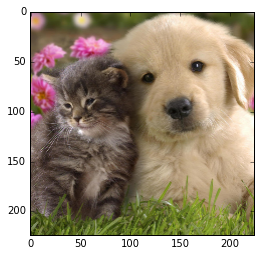

In [170]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [171]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=2,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]
        
        if next_word == "#UNK":
            continue
            
        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

a little girl kneeling down with a cat with a ring of her face
a baby cat chewing on inside of a book on a sunny day
a woman is standing near three little dogs in a restaurant
a little girl is eating a small carrot at the same time
a very cute cat with a pink hair looking at some sheep
a cat with a picture is a smile or a little boy is cleaning
a close up of an orange cat on the ground in front of a mirror
there is a baby that is laying a hanging on a bamboo
a cat laying in a small living area of a small white stuffed animal
a white and black and white image of a little blonde haired girl brushing her teeth of food


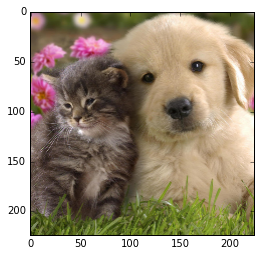

In [172]:
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a man in black shirt and a brown hat and a casual modern obama holding a briefcase
a man holding a rackett on top of a train
the man is taking a picture of himself in the mirror
a woman entering the nose of a metal instrument with a blue officer on it
a man stands next to a large machine
a male putting an apple in his container
the couple people are getting their put in a notebook
a person looking at a black bottle in a kitchen
a person standing at a desk holding a hair dryer
a man in the army black shirt holds a #UNK# while sitting in a store


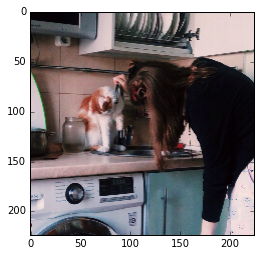

In [122]:
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

two small dogs are laying in front of the computer
a very long haired pretty little furry mother sleeping with a small teddy bear
a close up of a person holding a teddy bear
a white stuffed drinking yellow colored cat is surrounded by plants
a dog laying on top of a tall wooden bench in the sun
a couple of a woman holding a white container full of green vegetables
two black fluffy three photos of a cat having bad weather from face its eyes
a dog with a dog in a pile of some pictures
a gray rodent looks at the camera holding a #UNK#
two little white decor have white cats together


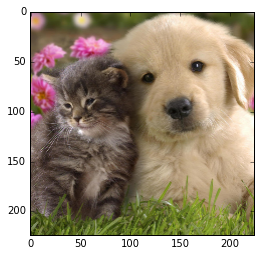

In [125]:
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

# TOP
two large white and tan colored pretty cats are very close together

# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 